## Representation of Board for Network

In [1]:
#from board import *...
#board.toVector()

# Neural Network Stuff
Trying to add pytorch stuff to the old code. 

In [18]:
import torch
import numpy as np
import neuralnetworks as nn
import math
import matplotlib.pyplot as plt
import pandas as pd
import mlutils as ml
import time

In [2]:
## Traditional arrays
X = np.arange(10).reshape((-1,1))
X = X.astype(float)
T = X + 1 + np.random.uniform(-1, 1, ((10,1)))

## torchy tensors (default to gpu)
Xt = torch.from_numpy(X.astype(float)).cuda() #converts to float for the .mean() call.
Tt = torch.from_numpy(T).cuda()

In [3]:
print(X)
print(Xt)

[[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]
 [7.]
 [8.]
 [9.]]
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]], device='cuda:0', dtype=torch.float64)


In [4]:
cpuNet = nn.NeuralNetwork(X.shape[1], 2, T.shape[1])

In [5]:
gpuNet = nn.NeuralNetwork(Xt.shape[1], 2, Tt.shape[1], True)

In [6]:
cpuNet.train(X,T,100)

NeuralNetwork(1, [2], 1)
   Network was trained for 101 iterations. Final error is 0.32780252256851294.

In [7]:
gpuNet.train(Xt,Tt,100)

NeuralNetwork(1, [2], 1)
   Network was trained for 101 iterations. Final error is 0.8597776191837884.

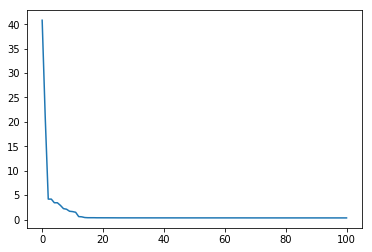

In [8]:
plt.plot(cpuNet.getErrors())

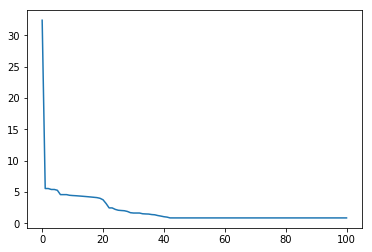

In [9]:
plt.plot(gpuNet.getErrors())

The above code doesn not get really reliable results. Could be something wrong with the scg though...

In [10]:
# testing with a5 data...
csv = pd.read_csv("energydata_complete.csv")
#drop unneeded columns
csv = csv.drop(['date', 'rv1', 'rv2'], axis = 1)
data = csv.values #.values is a numpy array! 
Tenergy = data[:, :2]
Xenergy = data[:, 2:]

In [14]:
testNN = nn.NeuralNetwork(Xenergy.shape[1], [10,10], Tenergy.shape[1])
testNN.train(Xenergy, Tenergy, 10000) #300 should be fine
#Final error is not the same as RMSE


NeuralNetwork(24, [10, 10], 2)
   Network was trained for 10001 iterations. Final error is 4715.99911828145.

In [15]:
XenergyGPU = torch.from_numpy(Xenergy).cuda()
TenergyGPU = torch.from_numpy(Tenergy).cuda()
testNNGPU = nn.NeuralNetwork(XenergyGPU.shape[1], [10,10], TenergyGPU.shape[1], True)
testNNGPU.train(XenergyGPU, TenergyGPU, 10000) #300 should be fine
#Final error is not the same as RMSE

NeuralNetwork(24, [10, 10], 2)
   Network was trained for 10001 iterations. Final error is 10074.343105026634.

In [16]:
def train(X, T, learning_rate_hidden, learning_rate_output, nHiddens, nIterations):
    nSamples = X.shape[0]
    nOutputs = T.shape[1]

    # Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
    V = 0.1*2*(np.random.uniform(size=(1+1, nHiddens))-0.5)
    W = 0.1*2*(np.random.uniform(size=(1+nHiddens ,nOutputs))-0.5)

    if not isinstance(X, np.ndarray):
        V = torch.from_numpy(V).cuda()
        W = torch.from_numpy(W).cuda()

    start_time = time.time()
    
    for step in range(nIterations):

        # Forward pass on training data
        if isinstance(X, np.ndarray):
            Z = np.tanh(X @ V[1:, :] + V[0:1, :])
        else:
            Z = (X @ V[1:, :] + V[0:1, :]).tanh()
        Y = Z @ W[1:, :] + W[0:1, :]

        # Error in output
        deltaW = (T - Y) / nSamples

        lrh = learning_rate_hidden
        lro = learning_rate_output
        # Backward pass - the backpropagation and weight update steps
        try:
            deltaV = (deltaW @ W[1:, :].T) * (1 - Z**2)
            V[1:, :] += lrh * X.T @ deltaV
            V[0:1, :] += lrh * deltaV.sum(0)
            W[1:, :] += lro * Z.T @ deltaW
            W[0:1, :] += lro * deltaW.sum()
        except:
            deltaV = (deltaW @ W[1:, :].t()) * (1 - Z**2)
            V[1:, :] += lrh * X.t() @ deltaV
            V[0:1, :] += lrh * deltaV.sum(0)
            W[1:, :] += lro * Z.t() @ deltaW
            W[0:1, :] += lro * deltaW.sum()
           
    print('train took', time.time() - start_time, 'seconds')
    
    return V, W
def use(X, V, W):
    if isinstance(X, np.ndarray):
        Z = np.tanh(X @ V[1:, :] + V[0:1, :])
    else:
        Z = (X @ V[1:, :] + V[0:1, :]).tanh()
    Y = Z @ W[1:, :] + W[0:1, :]
    return Y

In [21]:
V, W = train(Xenergy, Tenergy, 10, .01, 50, 100)

ValueError: shapes (19735,24) and (1,50) not aligned: 24 (dim 1) != 1 (dim 0)

In [24]:
def train_pytorch(X, T, learning_rate, nHiddens, nIterations, useAdam=False):
    
    class Torchnn(torch.nn.Module):
    
        def __init__(self, n_inputs, n_hidden_units, n_outputs):
            super(Torchnn, self).__init__()
            self.hidden = torch.nn.Linear(n_inputs, n_hidden_units) 
            self.tanh = torch.nn.Tanh()
            self.output = torch.nn.Linear(n_hidden_units, n_outputs)

        def forward(self, X):
            out = self.hidden(X)
            out = self.tanh(out)
            out = self.output(out)
            return out

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Running on', device)
    
    torchnn = Torchnn(1, nHiddens, 1).to(device).double()  # default is single precision
    
    if useAdam:
        optimizer = torch.optim.Adam(torchnn.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(torchnn.parameters(), lr=learning_rate)
    loss_func = torch.nn.MSELoss()
    
    errors = []
    startTime = time.time()

    for iteration in range(nIterations):
        # Forward pass
        outputs = torchnn(X)
        loss = loss_func(outputs, T)
        errors.append(torch.sqrt(loss))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Training took {} seconds'.format(time.time() - startTime))
    
    return torchnn, errors

In [25]:
torchnn, errors = train_pytorch(XenergyGPU, TenergyGPU, .01, 50, 100)

Running on cuda


RuntimeError: size mismatch, m1: [19735 x 24], m2: [1 x 50] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:249

Well this section seems to be dead to me. I cannot get anything to work consistently. We'll have to go with the old nn implementation and waiting instead. My server could work as well. 

## Reinforcement Learning With a Neural Network

Will be a combination of the NNet for Hanoi and tic tac toe.

First learn against a dumb opponent. 

Here is the representation of the board. *Unsure of which side should be player. Currently I think its red? Here represented as ones*

Here we train the red player?

In [7]:
from board import *
from piece import *

In [17]:
b = Board()
dr = b.draught
## add kings to show that they have *3 weight
blackKing = Piece(Color.BLACK, (0,1))
blackKing.king_me()
redKing = Piece(Color.RED, (7,6))
redKing.king_me()
dr[0, 1] = blackKing
dr[7, 6] = redKing
b.draught = dr
print(b)
print("The first of valid moves is seen easily in the board, from 0,5 to 4,1")
moves = b.validMoves()
b.stateMoveVectorForNN(moves[0])
#shows a vector representation of the board for the nerual network.
#see newStateRep in notebook 20(?) for more. 


      0 |  1 |  2 |  3 |  4 |  5 |  6 |  7
 0 | -  | BK | -  | B  | -  | B  | -  | B 
 1 | B  | -  | B  | -  | B  | -  | B  | - 
 2 | -  | B  | -  | B  | -  | B  | -  | B 
 3 | -  | -  | -  | -  | -  | -  | -  | - 
 4 | -  | -  | -  | -  | -  | -  | -  | - 
 5 | R  | -  | R  | -  | R  | -  | R  | - 
 6 | -  | R  | -  | R  | -  | R  | -  | R 
 7 | R  | -  | R  | -  | R  | -  | RK | - 

The first of valid moves is seen easily in the board, from 0,5 to 4,1


[0,
 -3,
 0,
 -1,
 0,
 -1,
 0,
 -1,
 -1,
 0,
 -1,
 0,
 -1,
 0,
 -1,
 0,
 0,
 -1,
 0,
 -1,
 0,
 -1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 3,
 0,
 5,
 0,
 4,
 1]